# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

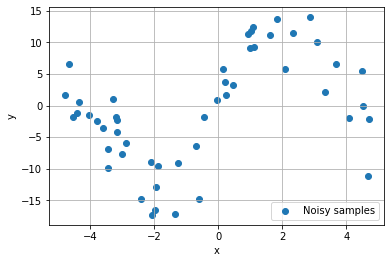

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

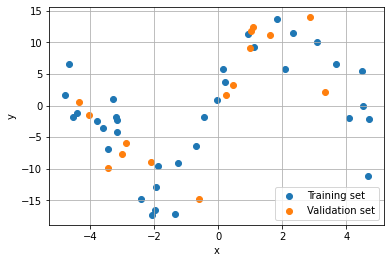

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

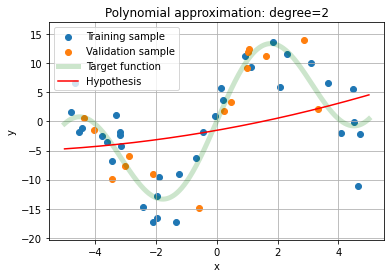

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

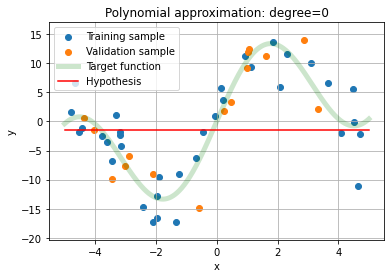

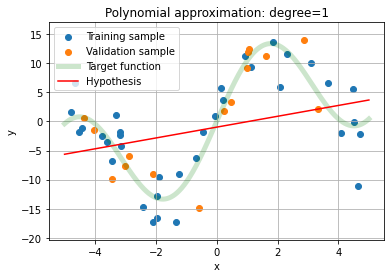

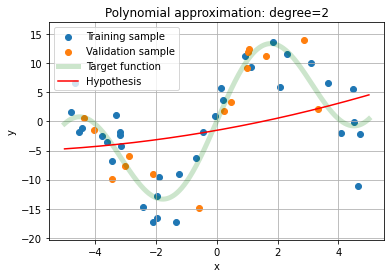

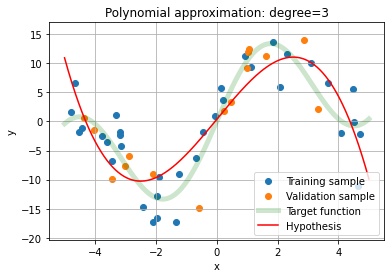

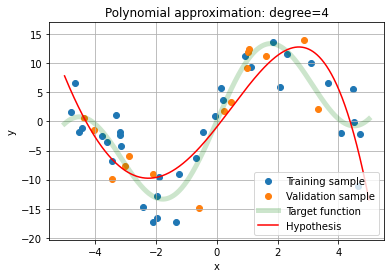

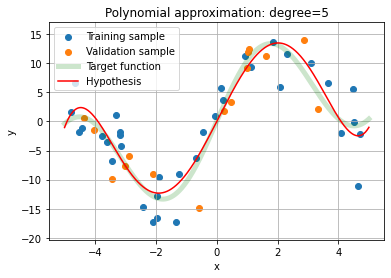

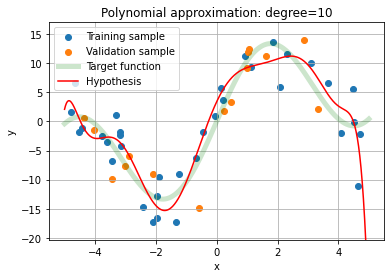

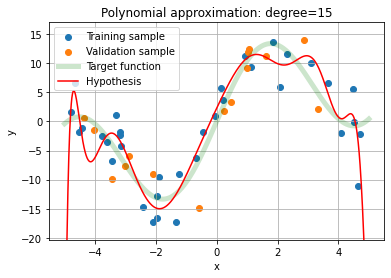

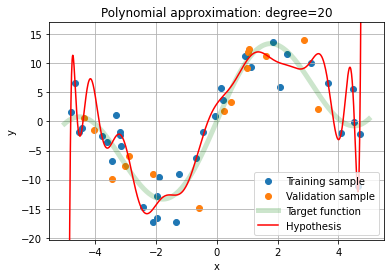

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

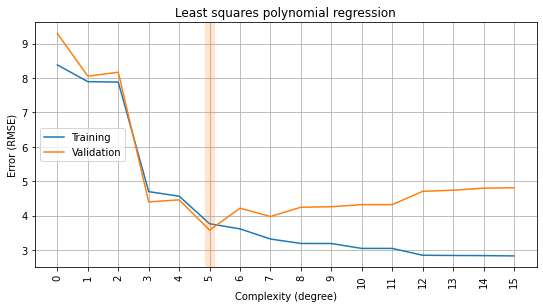

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

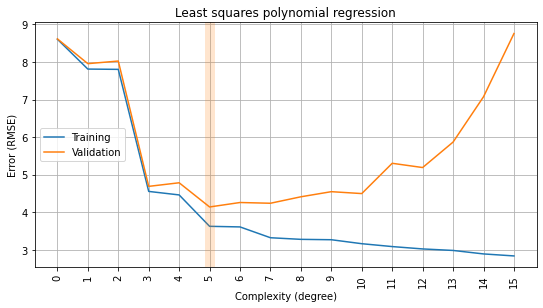

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

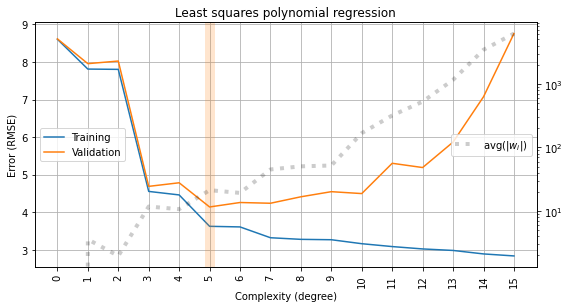

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

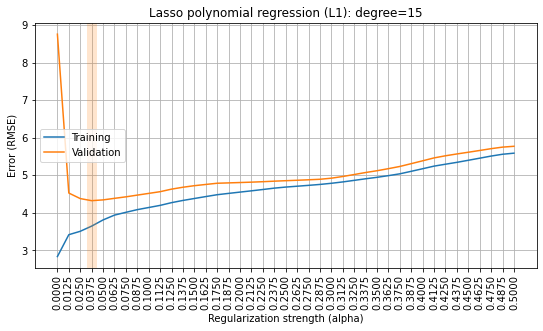

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

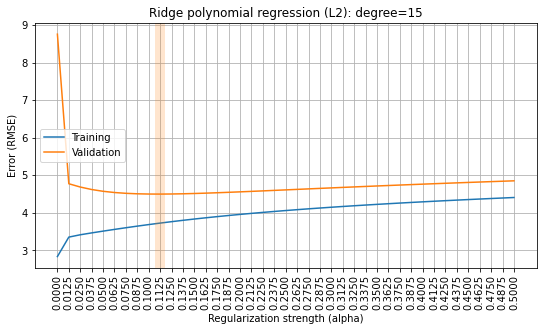

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
DEGREES = np.linspace(1, 15, 15, dtype=int)

Only two features will use to generate polynomial features (to be able to calculate on a slow machine for high degrees):

In [22]:
features_to_polynom = ['bmi', 's6']
rest_features = ['age', 'sex', 'bp', 's1', 's2', 's3', 's4', 's5']

*make_model_with_transformer* uses *ColumnTransformer* to generate polynomial features only for subset of all features:

In [23]:
def make_model_with_transformer(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000, tol=0.1)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('trans', ColumnTransformer(
            [('pol', PolynomialFeatures(degree, include_bias=(degree == 0)), features_to_polynom)], 
            remainder='passthrough'
        )),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

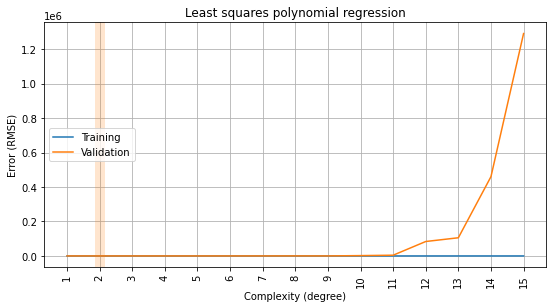

In [24]:
rmse_train, rmse_valid = [], []
x_train, x_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

for degree in DEGREES:
    reg = make_model_with_transformer(degree).fit(x_train, y_train)
    rmse_train.append(rmse(reg.predict(x_train), y_train))
    rmse_valid.append(rmse(reg.predict(x_test), y_test))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [25]:
print(np.min(rmse_valid), DEGREES[np.argmin(rmse_valid)])

52.66516983079554 2


52.66516983079554 2

**Summary:**  

Optimal degree is 2 (with minimal error)  
We can see overfitting with higher degrees (after degree 11 error getting sky-high)

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

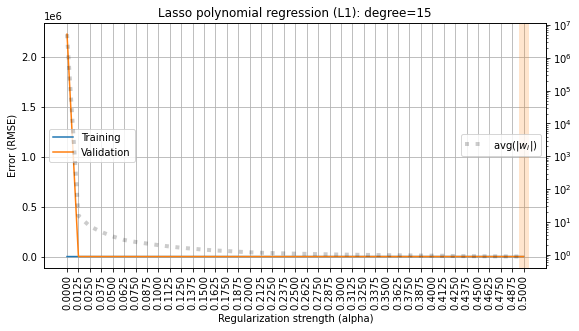

In [26]:
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS:
    results = cross_validate(make_model_with_transformer(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

L1 for alphas starting from 0.0125:

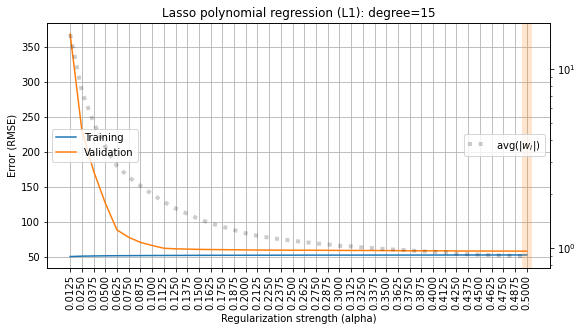

In [27]:
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS[1:]:
    results = cross_validate(make_model_with_transformer(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS[1:], rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

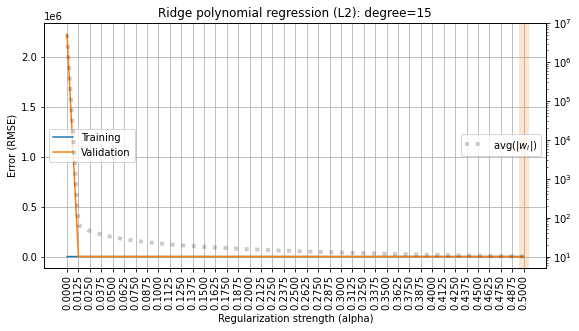

In [28]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model_with_transformer(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

L2 for alphas starting from 0.0125:

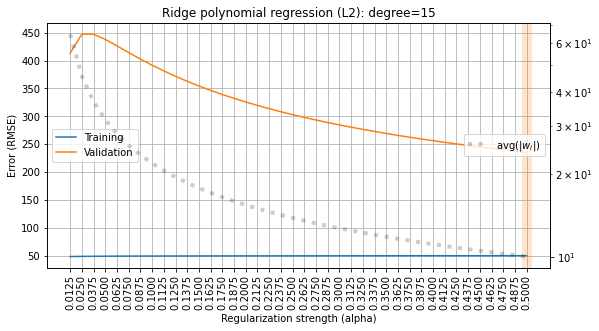

In [29]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS[1:]:    
    results = cross_validate(make_model_with_transformer(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS[1:], rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

**Summary:**

The influence of the regularization is controlled by the alpha parameter.  
Higher alpha means more regularization and simpler models.  
Regularization penalty prevents overfitting by restricting the model/constraining model coefficients.


### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [30]:
## your code
rmse_train, rmse_valid, avg_coef, coef = [], [], [], []

for alpha in ALPHAS:
    results = cross_validate(make_model_with_transformer(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=None,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    coef.append([model['reg'].coef_ for model in results['estimator']])

In [31]:
for idx in range(len(coef)):
    count_zeros_L1 = 0
    for cv_coef in coef[idx]:
        count_zeros_L1 += np.count_nonzero(cv_coef == 0)
    count_zeroes = round(count_zeros_L1 / len(coef[idx]))
    percentage = round((count_zeroes / len(cv_coef)) * 100, 1)
    print(f'For alpha {round(ALPHAS[idx], 4)} zeroes coef count: {count_zeroes} ({percentage}%)')

For alpha 0.0 zeroes coef count: 0 (0.0%)
For alpha 0.0125 zeroes coef count: 46 (32.2%)
For alpha 0.025 zeroes coef count: 52 (36.4%)
For alpha 0.0375 zeroes coef count: 56 (39.2%)
For alpha 0.05 zeroes coef count: 61 (42.7%)
For alpha 0.0625 zeroes coef count: 62 (43.4%)
For alpha 0.075 zeroes coef count: 64 (44.8%)
For alpha 0.0875 zeroes coef count: 66 (46.2%)
For alpha 0.1 zeroes coef count: 66 (46.2%)
For alpha 0.1125 zeroes coef count: 67 (46.9%)
For alpha 0.125 zeroes coef count: 69 (48.3%)
For alpha 0.1375 zeroes coef count: 72 (50.3%)
For alpha 0.15 zeroes coef count: 74 (51.7%)
For alpha 0.1625 zeroes coef count: 76 (53.1%)
For alpha 0.175 zeroes coef count: 77 (53.8%)
For alpha 0.1875 zeroes coef count: 78 (54.5%)
For alpha 0.2 zeroes coef count: 79 (55.2%)
For alpha 0.2125 zeroes coef count: 79 (55.2%)
For alpha 0.225 zeroes coef count: 81 (56.6%)
For alpha 0.2375 zeroes coef count: 82 (57.3%)
For alpha 0.25 zeroes coef count: 84 (58.7%)
For alpha 0.2625 zeroes coef count:

For alpha 0.0 zeroes coef count: 0 (0.0%)  
For alpha 0.0125 zeroes coef count: 46 (32.2%)  
For alpha 0.025 zeroes coef count: 52 (36.4%)  
For alpha 0.0375 zeroes coef count: 56 (39.2%)  
For alpha 0.05 zeroes coef count: 61 (42.7%)  
For alpha 0.0625 zeroes coef count: 62 (43.4%)  
For alpha 0.075 zeroes coef count: 64 (44.8%)  
For alpha 0.0875 zeroes coef count: 66 (46.2%)  
For alpha 0.1 zeroes coef count: 66 (46.2%)  
For alpha 0.1125 zeroes coef count: 67 (46.9%)  
For alpha 0.125 zeroes coef count: 69 (48.3%)  
For alpha 0.1375 zeroes coef count: 72 (50.3%)  
For alpha 0.15 zeroes coef count: 74 (51.7%)  
For alpha 0.1625 zeroes coef count: 76 (53.1%)  
For alpha 0.175 zeroes coef count: 77 (53.8%)  
For alpha 0.1875 zeroes coef count: 78 (54.5%)  
For alpha 0.2 zeroes coef count: 79 (55.2%)  
For alpha 0.2125 zeroes coef count: 79 (55.2%)  
For alpha 0.225 zeroes coef count: 81 (56.6%)  
For alpha 0.2375 zeroes coef count: 82 (57.3%)  
For alpha 0.25 zeroes coef count: 84 (58.7%)  
For alpha 0.2625 zeroes coef count: 82 (57.3%)  
For alpha 0.275 zeroes coef count: 83 (58.0%)  
For alpha 0.2875 zeroes coef count: 84 (58.7%)  
For alpha 0.3 zeroes coef count: 85 (59.4%)  
For alpha 0.3125 zeroes coef count: 86 (60.1%)  
For alpha 0.325 zeroes coef count: 86 (60.1%)  
For alpha 0.3375 zeroes coef count: 87 (60.8%)  
For alpha 0.35 zeroes coef count: 87 (60.8%)  
For alpha 0.3625 zeroes coef count: 88 (61.5%)  
For alpha 0.375 zeroes coef count: 88 (61.5%)  
For alpha 0.3875 zeroes coef count: 88 (61.5%)  
For alpha 0.4 zeroes coef count: 90 (62.9%)  
For alpha 0.4125 zeroes coef count: 89 (62.2%)  
For alpha 0.425 zeroes coef count: 84 (58.7%)  
For alpha 0.4375 zeroes coef count: 85 (59.4%)  
For alpha 0.45 zeroes coef count: 86 (60.1%)  
For alpha 0.4625 zeroes coef count: 87 (60.8%)  
For alpha 0.475 zeroes coef count: 87 (60.8%)  
For alpha 0.4875 zeroes coef count: 87 (60.8%)  
For alpha 0.5 zeroes coef count: 87 (60.8%)  

#### L2

In [32]:
## your code
rmse_train, rmse_valid, avg_coef, coef = [], [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model_with_transformer(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=None,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    coef.append([model['reg'].coef_ for model in results['estimator']])

In [33]:
for idx in range(len(coef)):
    count_zeros_L2 = 0
    for cv_coef in coef[idx]:
        count_zeros_L2 += np.count_nonzero(cv_coef == 0)
    print(f'For alpha {round(ALPHAS[idx], 4)} zeroes coef count: {round(count_zeros_L2 / len(coef[idx]))}')

For alpha 0.0 zeroes coef count: 0
For alpha 0.0125 zeroes coef count: 0
For alpha 0.025 zeroes coef count: 0
For alpha 0.0375 zeroes coef count: 0
For alpha 0.05 zeroes coef count: 0
For alpha 0.0625 zeroes coef count: 0
For alpha 0.075 zeroes coef count: 0
For alpha 0.0875 zeroes coef count: 0
For alpha 0.1 zeroes coef count: 0
For alpha 0.1125 zeroes coef count: 0
For alpha 0.125 zeroes coef count: 0
For alpha 0.1375 zeroes coef count: 0
For alpha 0.15 zeroes coef count: 0
For alpha 0.1625 zeroes coef count: 0
For alpha 0.175 zeroes coef count: 0
For alpha 0.1875 zeroes coef count: 0
For alpha 0.2 zeroes coef count: 0
For alpha 0.2125 zeroes coef count: 0
For alpha 0.225 zeroes coef count: 0
For alpha 0.2375 zeroes coef count: 0
For alpha 0.25 zeroes coef count: 0
For alpha 0.2625 zeroes coef count: 0
For alpha 0.275 zeroes coef count: 0
For alpha 0.2875 zeroes coef count: 0
For alpha 0.3 zeroes coef count: 0
For alpha 0.3125 zeroes coef count: 0
For alpha 0.325 zeroes coef count: 0

For all alpha zeroes coef count: 0

**Summary:**

Lasso regression has the effect of setting coefficients to zero for the least influential variables. This is called a sparse solution: a kind of feature selection.  
The big difference between Ridge and Lasso Regression is that Ridge Regression can only shrink coefficients close to 0 while Lasso Regression can shrink coefficients all the way to 0.  
Since Lasso Regression can exclude useless variables from equations, it is a little better than Ridge Regression at reducing the Variance in models that contain a lot of useless variables.  
In contrast, Ridge Regression tends to do a little better when most variables are useful.


### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [34]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


*make_model_without_scaler*:

In [35]:
def make_model_without_scaler(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('reg', regressor)
    ])


#### L1

**L1 with StandardScaler**:

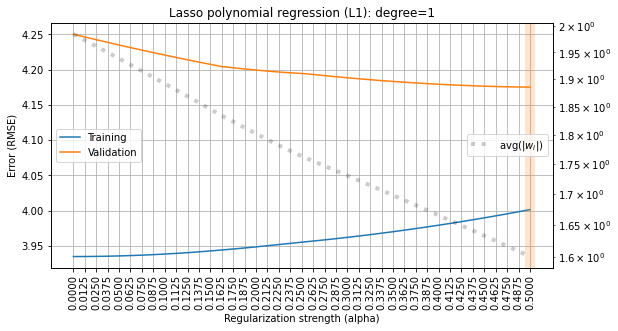

In [36]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS:
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=None,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=1')

**L1 without Scaler**:

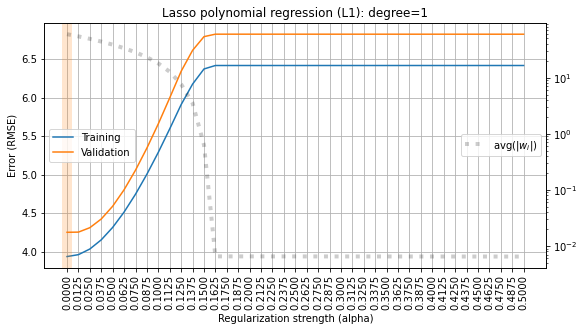

In [37]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model_without_scaler(degree=1, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=1')

#### L2

**L2 with StandardScaler**:

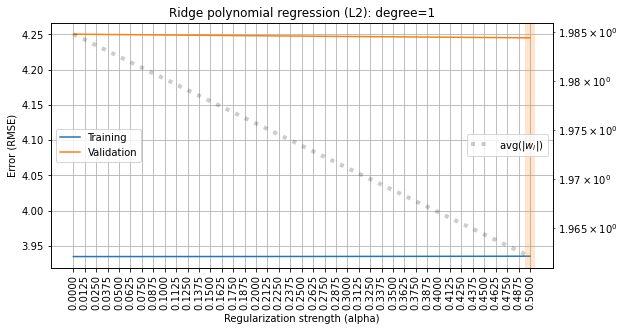

In [38]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=1')

**L2 without Scaler**:

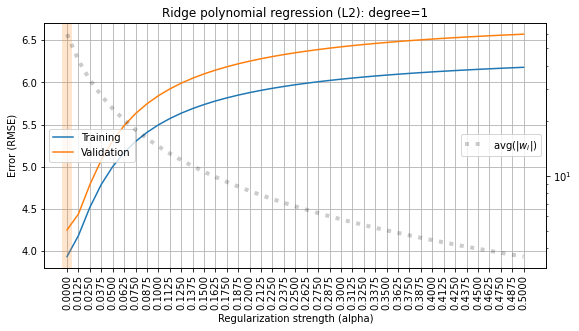

In [39]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model_without_scaler(degree=1, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
    ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=1')

**Summary:**

Scaling is important for some machine learning methods (regularized regression, kNN, SVM, NN, ...) that all features are on the same scale (e.g. faster convergence in learning, more uniform or 'fair' influence for all weight).  

In our example with scaling higher alpha reduces error for validation, without scaling it does not. 

Importance of scaling can depend on the data.

In our example Ridge Regression with degree 3 and higher without Scaler results in warning "result may not be accurate". It is because the features include large and small values, which are causing problems with the underlying linear algebra solver used to fit the model.